In [44]:
import numpy as np
import math
import sklearn.decomposition as sk
import seaborn as sns
sns.set_style("whitegrid")
sns.reset_orig()
import warnings
warnings.filterwarnings('ignore')
from scipy.special import gammainc
from scipy.special import lambertw
from scipy import stats
from matplotlib import pyplot as plt
import scipy.io
import random

import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import time
from os import path

def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros((len(X[0,:]),len(bins)))
    for j in range(len(map_to_bins[0,:])):
        for i in map_to_bins[:,j]:
            r[j,i-1] += 1
    return r

def randsphere(n_points,ndim,radius,center = []):
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def preprocessing(X,center,dimred,whiten,projectonsphere,ConditionalNumber = 10,ncomp=1):
    '''
    %preprocessing form preprocessed dataset
    %
    %Inputs
    %   X is n-by-d data matrix with n d-dimensional datapoints.
    %   center is boolean. True means subtraction of mean vector.
    %   dimred is boolean. True means applying of dimensionality reduction with
    %       PCA. Number of used PCs is defined by ConditionalNumber argument.
    %   whiten is boolean. True means applying of whitenning. True whiten
    %       automatically caused true dimred.
    %   projectonsphere is boolean. True means projecting data onto unit sphere
    %   varargin contains Name Value pairs. One possible value can be:
    %       'ConditionalNumber' - a positive real value used to select the top
    %           princinpal components. We consider only PCs with eigen values
    %           which are not less than the maximal eigenvalue divided by
    %           ConditionalNumber Default value is 10. 
    %
    %Outputs:
    %   X is preprocessed data matrix.'''
    
    #centering
    nobjects = len(X[:,0])
    sampleMean = np.mean(X,axis=0)
    if center:
        X = X-sampleMean
    #dimensionality reduction if requested dimensionality reduction or whitening
    PCAcomputed = 0
    if dimred or whiten:
        pca = sk.PCA()
        u = pca.fit_transform(X)
        v = pca.components_.T
        s = pca.explained_variance_
        PCAcomputed = 1
        sc = s/s[0]
        ind = np.where(sc > 1/ConditionalNumber)[0]
        X = X @ v[:,ind]
        if ncomp:
            print('%i components are retained using factor %2.2f' %(len(ind),ConditionalNumber))

    #whitening
    if whiten:
        X = u[:,ind]
        st = np.std(X,axis=0,ddof=1)
        X = X/st
    # #project on sphere (scale each vector to unit length)
    if projectonsphere:
        st = np.sqrt(np.sum(X**2,axis=1))
        st = np.array([st]).T
        X = X/st
    
    return X    

def probability_unseparable_sphere(alpha,n):
    ''' 
    %probability_unseparable_sphere calculate theoretical probability for point
    %to be inseparable for dimension n
    %
    %Inputs:
    %   alpha is 1-by-d vector of possible alphas. Must be row vector or scalar
    %   n is c-by-1 vector of dimnesions. Must be column vector or scalar.
    %
    %Outputs:
    %   p is c-by-d matrix of probabilities.'''
    p = np.power((1-np.power(alpha,2)),(n-1)/2)/(alpha*np.sqrt(2*np.pi*n))
    return p

def checkSeparability(xy,alpha):
    dxy = np.diag(xy)
    sm = (xy/dxy).T
    sm = sm - np.diag(np.diag(sm))
    sm = sm>alpha
    py = sum(sm.T)
    py = py/len(py[0,:])
    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction,py

def checkSeparabilityMultipleAlpha(data,alpha):
    '''%checkSeparabilityMultipleAlpha calculate fraction of points inseparable
    %for each alpha and fraction of points which are inseparable from each
    %point for different alpha.
    %
    %Inputs:
    %   data is data matrix to calculate separability. Each row contains one
    %       data point.
    %   alpha is array of alphas to test separability.
    %
    %Outputs:
    %   separ_fraction fraction of points inseparable from at least one point.
    %       Fraction is calculated for each alpha.
    %   py is n-by-m matrix. py(i,j) is fraction of points which are
    %       inseparable from point data(i, :) for alphas(j).'''


    #Number of points per 1 loop. 20k assumes approx 3.2GB
    nP = 20000

    #Normalize alphas
    if len(alpha[:,0])>1:
        alpha = alpha.T
    addedone = 0
    if max(alpha[0,:])<1:
        alpha = np.array([np.append(alpha,1)])
        addedone = 1

    alpha = np.concatenate([[float('-inf')],alpha[0,:], [float('inf')]])

    n = len(data)
    counts = np.zeros((n, len(alpha)))
    leng = np.zeros((n, 1))
    for k in range(0,n,nP):
        #print('Chunk +{}'.format(k))
        e = k + nP 
        if e > n:
            e = n
        # Calculate diagonal part, divide each row by diagonal element
        xy = data[k:e, :] @ data[k:e, :].T
        leng[k:e] = np.diag(xy)[:,None]
        xy = xy - np.diag(leng[k:e].squeeze())
        xy = xy / leng[k:e]
        counts[k:e, :] = counts[k:e, :] + histc(xy.T, alpha)
        # Calculate nondiagonal part
        for kk in range(0,n,nP):
            #Ignore diagonal part
            if k == kk:
                continue                         
            ee = kk + nP 
            if ee > n:
                ee = n

            xy = data[k:e, :] @ data[kk:ee, :].T
            xy = xy / leng[k:e]
            counts[k:e, :] = counts[k:e, :] + histc(xy.T, alpha)

    #Calculate cumulative sum
    counts = np.cumsum(counts[:,::-1],axis=1)[:,::-1]
    
    #print(counts)

    py = counts/(n-1)
    py = py.T
    if addedone:
        py = py[1:-2,:]
    else:
        py = py[1:-1,:]

    separ_fraction = sum(py==0)/len(py[0,:])
    
    return separ_fraction, py

def dimension_uniform_sphere(py,alphas,number_of_data_points):
    '''
    %Gives an estimation of the dimension of uniformly sampled n-sphere
    %corresponding to the average probability of being unseparable and a margin
    %value 
    %
    %Inputs:
    %   py - average fraction of data points which are INseparable.
    %   alphas - set of values (margins), must be in the range (0;1)
    % It is assumed that the length of py and alpha vectors must be of the
    % same.
    %
    %Outputs:
    %   n - effective dimension profile as a function of alpha
    %   n_single_estimate - a single estimate for the effective dimension 
    %   alfa_single_estimate is alpha for n_single_estimate.
    '''
    
    if len(py)!=len(alphas[0,:]):
        raise ValueError('length of py (%i) and alpha (%i) does not match'%(len(py),len(alpha[0,:])))
    
    if np.sum(alphas <= 0) > 0 or np.sum(alphas >= 1) > 0:
        raise ValueError(['"Alphas" must be a real vector, with alpha range, the values must be within (0,1) interval'])

    #Calculate dimension for each alpha
    n = np.zeros((len(alphas[0,:])))
    for i in range(len(alphas[0,:])):
        if py[i] == 0:
            #All points are separable. Nothing to do and not interesting
            n[i]=np.nan
        else:
            p  = py[i]
            a2 = alphas[0,i]**2
            w = np.log(1-a2)
            n[i] = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)
 
    n[n==np.inf] = float('nan')
    #Find indices of alphas which are not completely separable 
    inds = np.where(~np.isnan(n))[0]
    #Find the maximal value of such alpha
    alpha_max = max(alphas[0,inds])
    #The reference alpha is the closest to 90 of maximal partially separable alpha
    alpha_ref = alpha_max*0.9
    k = np.where(abs(alphas[0,inds]-alpha_ref)==min(abs(alphas[0,:]-alpha_ref)))[0]
    #Get corresponding values
    alfa_single_estimate = alphas[0,inds[k]]
    n_single_estimate = n[inds[k]]
    
    return n,n_single_estimate,alfa_single_estimate

def SeparabilityAnalysis_matlab(X):
    np.savetxt("C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_input.txt", X, delimiter="\t")
    !rm C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_nalpha_single.txt
    !matlab -nosplash -nodesktop -r "cd('C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/'); Separability_script"
    while not path.exists("C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_nalpha_single.txt"):
        time.sleep(1)
    time.sleep(1)
    pp = pd.read_csv('C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_palpha.txt', sep='\t',header=None)
    p_alpha = pp.to_numpy()[:,0:-1]
    pp = pd.read_csv('C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_nalpha.txt', sep='\t',header=None)
    n_alpha = pp.to_numpy()[:,0]
    pp = pd.read_csv('C:/MyPrograms/_github/FisherSeparabilityAnalysis/MATLAB/_nalpha_single.txt', sep='\t',header=None)
    n_single = pp.to_numpy()[0,0]
    p_alpha = p_alpha.T
    return n_alpha,n_single,p_alpha

def SeparabilityAnalysis(X,ConditionalNumber=10,ProjectOnSphere = 1,alphas = np.array([np.arange(.6,1,.02)]),ProducePlots = 1,ncomp = 0):
    '''
    %Performs standard analysis of separability and produces standard plots. 
    %
    %Inputs:
    %   X  - is a data matrix with one data point in each row.
    %   Optional arguments in varargin form Name, Value pairs. Possible names:
    %       'ConditionalNumber' - a positive real value used to select the top
    %           princinpal components. We consider only PCs with eigen values
    %           which are not less than the maximal eigenvalue divided by
    %           ConditionalNumber Default value is 10.
    %       'ProjectOnSphere' - a boolean value indicating if projecting on a
    %           sphere should be performed. Default value is true.
    %       'Alphas' - a real vector, with alpha range, the values must be given increasing
    %           within (0,1) interval. Default is [0.6,0.62,...,0.98].
    %       'ProducePlots' - a boolean value indicating if the standard plots
    %           needs to be drawn. Default is true.
    %       'ncomp' - whether to print number of retained principal components
    %Outputs:
    %   n_alpha - effective dimension profile as a function of alpha
    %   n_single - a single estimate for the effective dimension 
    %   p_alpha - distributions as a function of alpha, matrix with columns
    %       corresponding to the alpha values, and with rows corresponding to
    %       objects. 
    %   separable_fraction - separable fraction of data points as a function of
    %       alpha
    %   alphas - alpha values
    '''
    npoints = len(X[:,0])
    # Preprocess data
    Xp = preprocessing(X,1,1,1,ProjectOnSphere,ConditionalNumber=ConditionalNumber,ncomp=ncomp)
    # Check separability
    [separable_fraction,p_alpha] = checkSeparabilityMultipleAlpha(Xp,alphas)    
    # Calculate mean of fraction of separable points for each alpha.
    py_mean = np.mean(p_alpha,axis=1)    
    [n_alpha,n_single,alpha_single] = dimension_uniform_sphere(py_mean,alphas,npoints)

    alpha_ind_selected = np.where(n_single==n_alpha)[0]
    
    if ProducePlots:
        #Define the minimal and maximal dimensions for theoretical graph with
        # two dimensions in each side
        n_min = np.floor(min(n_alpha))-2;
        n_max = np.floor(max(n_alpha)+0.8)+2;
        if n_min<1:
            n_min = 1

        ns = np.arange(n_min,n_max+1)
        
        plt.figure()
        plt.plot(alphas[0,:],n_alpha,'ko-');plt.plot(alphas[0,alpha_ind_selected],n_single,'rx',markersize=16)
        plt.xlabel('\u03B1',fontsize=16); plt.ylabel('Effective dimension',fontsize=16) ; locs, labels = plt.xticks(); plt.show()
        nbins = int(round(np.floor(npoints/200)))

        if nbins<20:
            nbins = 20
        

        plt.figure()
        plt.hist(p_alpha[alpha_ind_selected,:][0],bins=nbins)
        plt.xlabel('unseparability prob.p for \u03B1=%2.2f'%(alphas[0,alpha_ind_selected]),fontsize=16); plt.ylabel('Number of values');plt.show()

        plt.figure()
        plt.xticks(locs,labels);
        pteor = np.zeros((len(ns),len(alphas[0,:])))
        for k in range(len(ns)):
            for j in range(len(alphas[0,:])):
                pteor[k,j] = probability_unseparable_sphere(alphas[0,j],ns[k])

        for i in range(len(pteor[:,0])):
            plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1)
        if True in np.isnan(n_alpha):
            plt.semilogy(alphas[0,:np.where(np.isnan(n_alpha))[0][0]],py_mean[:np.where(np.isnan(n_alpha))[0][0]],'bo-','LineWidth',3);
        else: 
            plt.semilogy(alphas[0,:],py_mean,'bo-','LineWidth',3);

        plt.xlabel('\u03B1'); plt.ylabel('Mean unseparability prob.',fontsize=16);
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))
        plt.show()


    return n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp

def ismember(A, B):
    return [ B[a] for a in A ]

def list2dict(lst):
    dct = {}
    for s,i in enumerate(lst):
        dct[i] = s
    return dct


<class 'numpy.ndarray'>


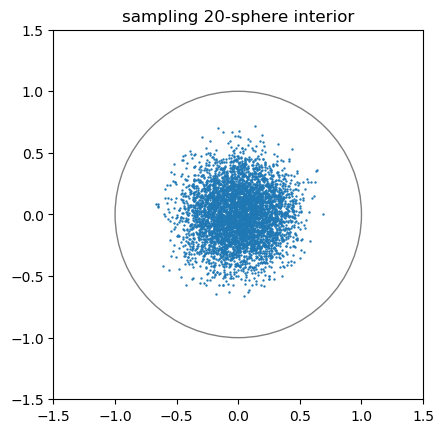

(5000, 20)
(20, 5000)
20.0


In [38]:
# Simplest test - uniform distribution of k points on a N-dimensional sphere, determining N from the distribution

fig1 = plt.figure()
ax1 = fig1.gca()
npoints = 5000
dimension = 20
radius = 1
X,center = randsphere(npoints,dimension,radius)
print(type(X))
ax1.scatter(X[:,0],X[:,1],s=0.5)
ax1.add_artist(plt.Circle(center,radius,fill=False,color='0.5'))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1.5,1.5)
ax1.set_aspect('equal')
ax1.set_title('sampling %i-sphere interior'%dimension)
plt.show()

print(X.shape)
#[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(X)
[n_alpha,n_single,p_alpha,retained_dim] = SeparabilityAnalysis_matlab(X)
print(p_alpha.shape)
print(retained_dim)

In [35]:
# Work with BCNN data, loading a dataset

#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive
#folder = '/gdrive/My Drive/Kharchenko_BCNN/'
#file = 'Sst.txt'


load_all = False

folder = 'C:/Datas/Kharchenko_BCNN/'

if not load_all:
    file = 'Sst.txt'
    #df = pd.read_csv(folder+'bytype/'+file,sep='\t')
    df = pd.read_csv(folder+file,sep='\t')
    #print(df)
    dft = df.transpose()
    #print(dft)
    list_of_samples = df.columns[1:-1].to_list()
    print('Number of columns = {}'.format(len(list_of_samples)))
    #x = df.to_numpy()[:,1:]
    # this is to treat an artefact of last empty column if needed
    x = df.to_numpy()[:,1:-1]
    x = x.T
else:
    file = 'pca.txt'
    df = pd.read_csv(folder+file,sep='\t')
    list_of_samples = df.SAMPLE[1:].to_list()
    #print(list_of_samples)
    print('Number of samples = {}'.format(len(list_of_samples)))
    x = df.to_numpy()[:,1:]

print(x.shape)
print(x)

annot_file = 'clusterings5.txt'
annot_df = pd.read_csv(folder+annot_file,sep='\t')
print(annot_df)
samplesAnn = annot_df['SAMPLE'].tolist()
print('Number of samples = {}'.format(len(samplesAnn)))
samplesAnnDict = list2dict(samplesAnn)

irx = ismember(list_of_samples,samplesAnnDict)
clusters =  annot_df.loc[irx,'CLUSTER'].tolist()
unique_clusters = list(set(clusters))

cluster_counts = []
for s in unique_clusters:
    cluster_counts.append(clusters.count(s))
big_clusters = []
for i,s in enumerate(unique_clusters):
    print(str(s)+' {}'.format(cluster_counts[i]))
    if cluster_counts[i]>100:
        big_clusters.append(s)

print(big_clusters)

Number of columns = 2334
(2334, 50)
[[23.041 1.909 1.547 ... -2.369 1.89 6.86]
 [19.537 0.7609999999999999 0.426 ... -0.98 0.807 3.366]
 [18.512 2.0540000000000003 -0.5 ... -2.33 -0.6709999999999999 2.785]
 ...
 [21.589000000000002 -2.958 1.0290000000000001 ... 1.758 1.555
  -10.610999999999999]
 [22.570999999999998 -2.4819999999999998 0.479 ... 1.7369999999999999
  2.76 -12.773]
 [23.78 -2.767 1.79 ... 2.633 0.795 -10.538]]
                                     SAMPLE  CLUSTER
0      AAACCTGAGGGCTCTC-4L8TX_171026_01_F04        3
1      AAACCTGCAAGGACAC-4L8TX_171026_01_F04        1
2      AAACCTGCAATTCCTT-4L8TX_171026_01_F04       59
3      AAACCTGCAGTCGATT-4L8TX_171026_01_F04       40
4      AAACCTGCATGTAAGA-4L8TX_171026_01_F04       49
...                                     ...      ...
35830  TTTGTCATCACGGTTA-8L8TX_171026_01_A05       28
35831  TTTGTCATCGGTCTAA-8L8TX_171026_01_A05        6
35832  TTTGTCATCTCCCTGA-8L8TX_171026_01_A05       20
35833  TTTGTCATCTGAGTGT-8L8TX_171026_01_A

Computing PCA...
(2334, 50)
 Elapsed time 0.03 s


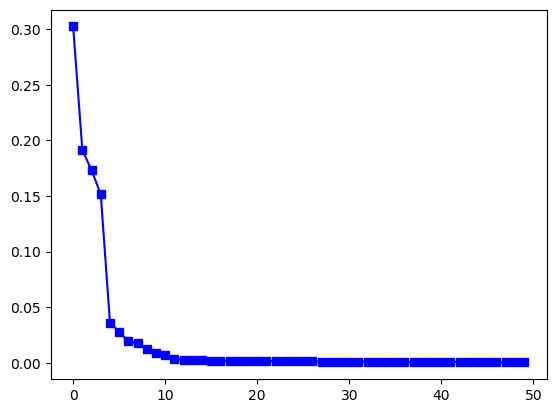

In [36]:
# Work with BCNN data, computing PCA

pca = PCA()
print('Computing PCA...')
start_time = time.time()
pcs = pca.fit_transform(x)
print(pcs.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))
ev = pca.explained_variance_ratio_

plt.figure(0)
plt.plot(ev,'bs-')
plt.show()

In [48]:
# Work with BCNN data, computing UMAP and tSNE embeddings

knn = max(5,int(x.shape[0]/20))
knn = 20
reducer = umap.UMAP(n_neighbors=knn)
print('Computing UMAP...')
start_time = time.time()
umap_emb = reducer.fit_transform(x)
print(umap_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))

print('Computing tSNE...')
start_time = time.time()
tsne_emb = TSNE(n_components=2).fit_transform(x)
print(tsne_emb.shape)
print(' Elapsed time %2.2f s' % ((time.time() - start_time)))


Computing UMAP...
(2334, 2)
 Elapsed time 9.48 s
Computing tSNE...
(2334, 2)
 Elapsed time 19.20 s


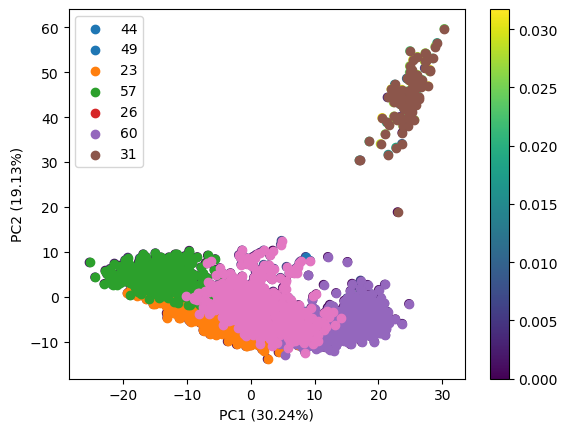

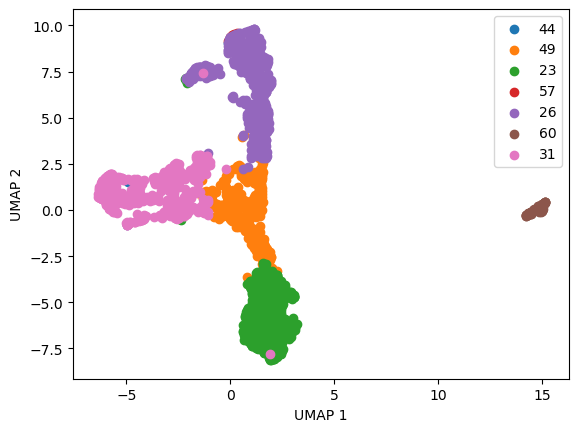

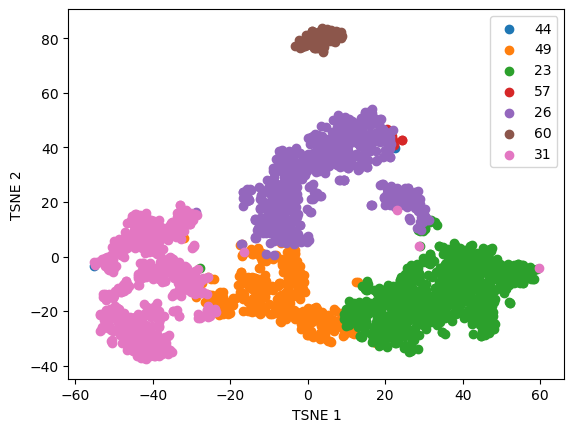

In [49]:
# Work with BCNN data, plotting by classes

colors = ['red','green','blue','maroon','magenta','lime','skyblue','darkgrey','black','gold','purple']
c = []
for i in range(1,1000):
    for j in range(1,len(colors)):
        c.append(colors[j])
colors = c
labels = ['']*len(unique_clusters)
for i,s in enumerate(unique_clusters):
    labels[i] = str(s)

# PCA
plt.figure(0)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(pcs[irx,0],pcs[irx,1])
plt.legend(labels)    
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)

# UMAP
plt.figure(1)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(umap_emb[irx,0],umap_emb[irx,1])
plt.legend(labels)    
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)

# TSNE
plt.figure(2)
for i,s in enumerate(unique_clusters):
    color = colors[i]
    irx = [i for i, n in enumerate(clusters) if (n == s)]
    plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1])
plt.legend(labels)    
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)

plt.show()



In [45]:
# separability analysis

ConditionalNumber = 100

start_time = time.time()
#[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(x.astype(np.float64),ConditionalNumber=ConditionalNumber,ncomp=1)
#Retained_dimension = Xp.shape[1]

Retained_dimension = 12
pca = sk.PCA()
u = pca.fit_transform(x)
x_projected = u[:,0:Retained_dimension]
[n_alpha,n_single,p_alpha] = SeparabilityAnalysis_matlab(x_projected.astype(np.float64))

print(Retained_dimension)
print("Elapsed time = {}".format(time.time()-start_time))

12
Elapsed time = 13.496439456939697


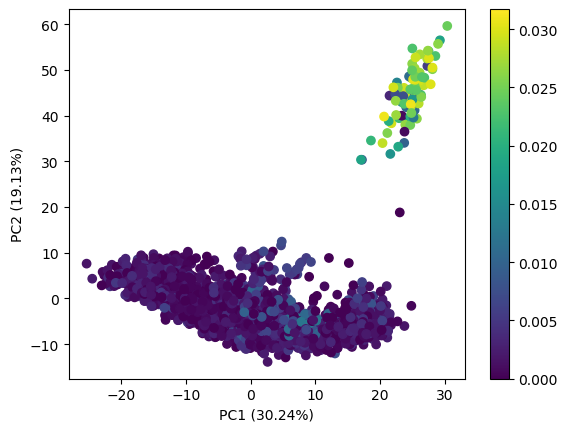

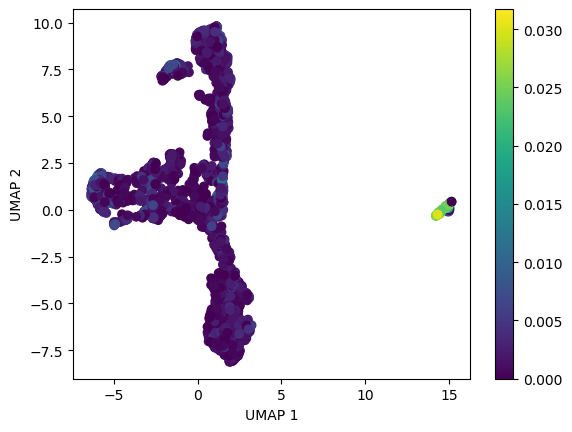

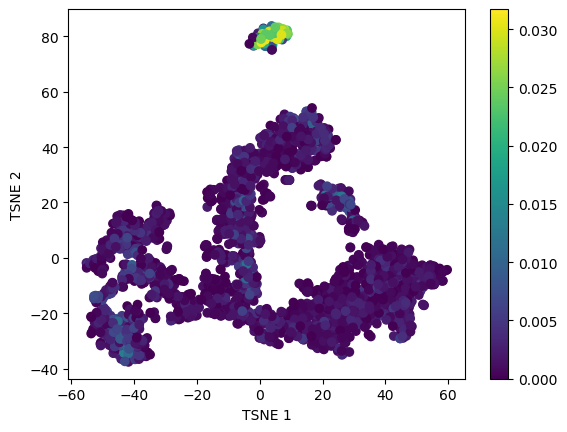

In [50]:
# plotting separability distribution

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*0
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]

c=p_alpha[alpha_index,irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()




0.00343


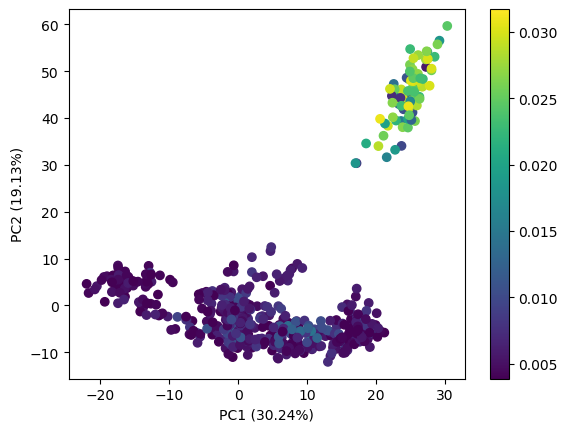

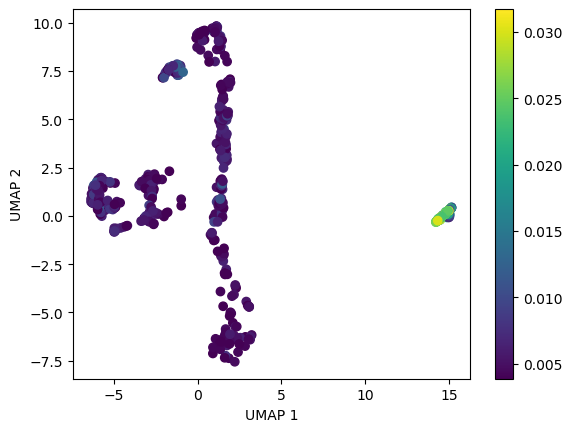

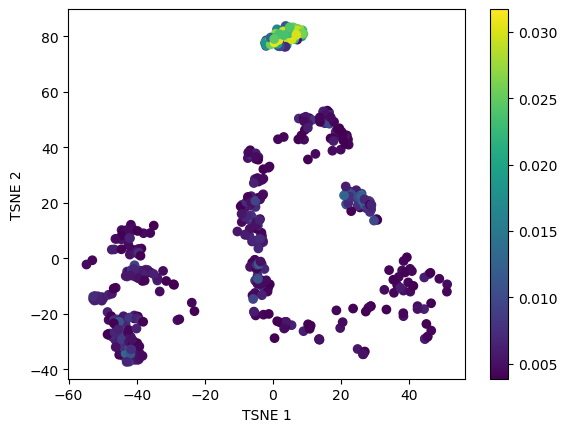

In [52]:
# plotting separability distribution

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*2
print(threshold)
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]

c=p_alpha[alpha_index,irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()


In [47]:
pca = sk.PCA()
u = pca.fit_transform(x)
x_projected = u[:,0:Retained_dimension]
print(x_projected.shape)

(2334, 12)


In [54]:
# testing separability saturation

n_samples = x.shape[0]
print('Number of sample = {}'.format(n_samples))

#sample_sizes = [2,5,7,10,15,20,25,30,40,50,60,70,80,90]
sample_sizes = [5,7,10,15,20,25,30,50,70,90]
#sample_sizes = [5,10,50]
sample_sizes_halves = [x/2 for x in sample_sizes]
all_sample_sizes = sample_sizes+sample_sizes_halves
all_sample_sizes = list(set(all_sample_sizes))
all_sample_sizes.sort()
n_repeats = 30

dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])

print('Number of dimensions retained {}'.format(Retained_dimension))
x_proj = pcs[:,0:Retained_dimension]

for i,sz in enumerate(all_sample_sizes):
    sample_size = int(n_samples*sz/100)
    print('Sample size = {}'.format(sample_size))
    start_time = time.time()
    for j in range(0,n_repeats):
        sample = np.random.randint(0,n_samples,size=sample_size)
        xs = x_proj[sample,:]
        [n_alpha_s,n_single_s,p_alpha_s,alphas_s,separable_fraction_s,Xp_s] = SeparabilityAnalysis(xs.astype(np.float64),ConditionalNumber=100000,ProducePlots=False)
        #print(n_single_s.astype(np.float64))
        dim_estimates[i,j] = n_single_s.astype(np.float64)
    print("Elapsed time = {}".format(time.time()-start_time))
        
[n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(x_proj.astype(np.float64),ConditionalNumber=100000,ProducePlots=False)
for i in range(0,n_repeats):
    dim_estimates[len(all_sample_sizes),i] = n_single
all_sample_sizes.append(100)
sample_sizes.append(100)

np.savetxt("dim_estimates.txt", dim_estimates, delimiter="\t")
np.savetxt("all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
np.savetxt("sample_sizes.txt", sample_sizes, delimiter="\t")

Number of sample = 2334
Number of dimensions retained 12
Sample size = 58
Elapsed time = 0.1869955062866211
Sample size = 81
Elapsed time = 0.29433274269104004
Sample size = 116
Elapsed time = 0.5669746398925781
Sample size = 163
Elapsed time = 1.4651610851287842
Sample size = 175
Elapsed time = 1.2089593410491943
Sample size = 233
Elapsed time = 3.026681900024414
Sample size = 291
Elapsed time = 3.1710898876190186
Sample size = 350
Elapsed time = 4.968641042709351
Sample size = 466
Elapsed time = 7.910595893859863
Sample size = 583
Elapsed time = 11.810124158859253
Sample size = 700
Elapsed time = 17.011456966400146
Sample size = 816
Elapsed time = 22.612982511520386
Sample size = 1050
Elapsed time = 41.50120210647583
Sample size = 1167
Elapsed time = 51.21856880187988
Sample size = 1633
Elapsed time = 96.97237253189087
Sample size = 2100
Elapsed time = 150.8586926460266


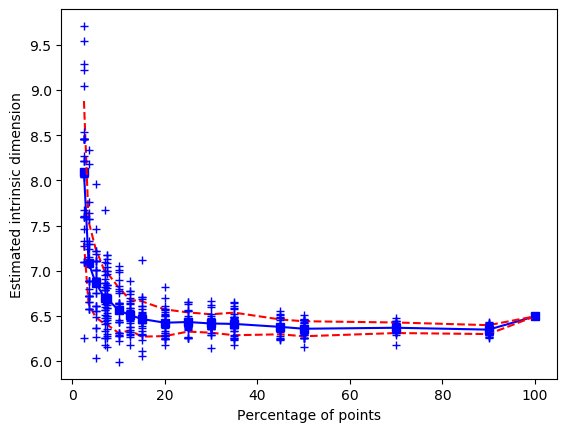

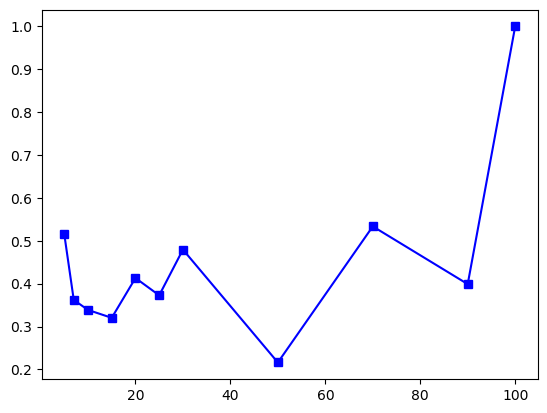

In [60]:
# plot convergence curve


alls=pd.read_csv('all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]
sizes=pd.read_csv('sample_sizes.txt', sep='\t',header=None)
sample_sizes =sizes.to_numpy()[:,0]
ds=pd.read_csv('dim_estimates.txt', sep='\t',header=None)
dim_estimates=ds.to_numpy()

#print(all_sample_sizes)
#print(sample_sizes)

#print(np.mean(dim_estimates[:,:],1).shape)
mn = np.mean(dim_estimates[:,:],1)
std = np.std(dim_estimates[:,:],1)

plt.figure(0)
plt.plot(all_sample_sizes,mn,'bs-')
plt.plot(all_sample_sizes,mn-std,'r--')
plt.plot(all_sample_sizes,mn+std,'r--')
plt.plot(all_sample_sizes,dim_estimates,'b+')
plt.xlabel('Percentage of points')
plt.ylabel('Estimated intrinsic dimension')
plt.show()

#print(std)

ratios = []
for sz in sample_sizes:
    sz_half = sz/2
    k = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz-asz)<0.001 ][0]
    k_half = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz_half-asz)<0.001 ][0]
    #print(k,all_sample_sizes[k],k_half,all_sample_sizes[k_half])
    ratios.append(1-std[k]/std[k_half])

plt.figure(1)
plt.plot(sample_sizes,ratios,'bs-')
plt.show()
    

In [96]:
# random selection of clusters

number_of_repeats = 5
number_of_clusters = len(big_clusters)

print('Number of dimensions retained {}'.format(Retained_dimension))
x_proj = pcs[:,0:Retained_dimension]

dim_est_clusters = np.empty([number_of_clusters,number_of_repeats])
print(dim_est_clusters.shape)

for nc in range(1,number_of_clusters):
    for reap in range(0,number_of_repeats):
        cluster_selection = random.sample(big_clusters, nc)
        irx = [i for i,cl in enumerate(clusters) if cl in cluster_selection]
        xsel = x_proj[irx,:]
        [n_alpha_s,n_single_s,p_alpha_s,alphas_s,separable_fraction_s,Xp_s] = SeparabilityAnalysis(xsel.astype(np.float64),ConditionalNumber=100000,ProducePlots=False)
        dim_est_clusters[nc-1,reap] = n_single_s.astype(np.float64)
        print(nc,reap,n_single_s)
        #alpha_index = (n_alpha==n_single).tolist().index(True)
        #palpha_selected = p_alpha[alpha_index,:]
        #c=p_alpha[alpha_index,irx]
        #plt.scatter(xsel[:,0],xsel[:,1],c=c)
        #plt.show()
        
for i in range(0,number_of_repeats):
    dim_est_clusters[number_of_clusters-1,i] = n_single

print(dim_est_clusters)

Number of dimensions retained 12
(4, 5)
1 0 [8.42529957]
1 1 [8.42529957]
1 2 [10.65127122]
1 3 [8.42529957]
1 4 [8.51850429]
2 0 [7.21883892]
2 1 [7.68982004]
2 2 [8.49032068]
2 3 [8.26252926]
2 4 [8.34523672]
3 0 [7.93278439]
3 1 [8.37465575]
3 2 [7.10280544]
3 3 [8.37465575]
3 4 [7.10280544]
[[ 8.42529957  8.42529957 10.65127122  8.42529957  8.51850429]
 [ 7.21883892  7.68982004  8.49032068  8.26252926  8.34523672]
 [ 7.93278439  8.37465575  7.10280544  8.37465575  7.10280544]
 [ 6.49362329  6.49362329  6.49362329  6.49362329  6.49362329]]


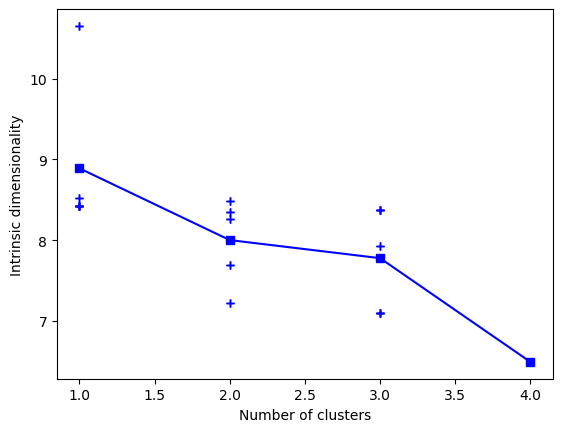

In [101]:
# plot dependence of ID vs number of clusters

plt.figure(0)
plt.plot(range(1,number_of_clusters+1),dim_est_clusters,'b+')
plt.plot(range(1,number_of_clusters+1),np.mean(dim_est_clusters,1),'bs-')
plt.xlabel('Number of clusters')
plt.ylabel('Intrinsic dimensionality')
plt.show()

In [ ]:
# compare separability with KDE density estimate

mu=np.array([1,10,20])
sigma=np.matrix([[4,10,0],[10,25,0],[0,0,100]])
data=np.random.multivariate_normal(mu,sigma,1000)
values = data.T

values = x.T
values = values.astype(np.float64)

kde = stats.gaussian_kde(values)
density = kde(values)
density = density/np.max(density)

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]

plt.figure(0)
plt.plot(density,palpha_selected,'bs')
plt.xlabel('KDE estimate (density)')
plt.ylabel('Unseparability')
plt.show()

# we filter by separability (if needed, show low-dimensional part of the distribution)
threshold = np.median(palpha_selected)*0
irx = [i for i, n in enumerate(palpha_selected) if (n >= threshold)]
c=density[irx]
#c= [clusters[i] for i in irx]

plt.figure(0)
plt.scatter(pcs[irx,0],pcs[irx,1],c=c)
plt.xlabel('PC1 ({:.2f}%)'.format(ev[0]*100), fontsize = 10)
plt.ylabel('PC2 ({:.2f}%)'.format(ev[1]*100), fontsize = 10)
plt.colorbar()

plt.figure(1)
plt.scatter(umap_emb[irx,0],umap_emb[irx,1],c=c)
plt.xlabel('UMAP 1', fontsize = 10)
plt.ylabel('UMAP 2', fontsize = 10)
plt.colorbar()

plt.figure(2)
plt.scatter(tsne_emb[irx,0],tsne_emb[irx,1],c=c)
plt.xlabel('TSNE 1', fontsize = 10)
plt.ylabel('TSNE 2', fontsize = 10)
plt.colorbar()

plt.show()


